# Import libraries

In [1]:
import sys
import os
import time
import numpy as np
from snAPI.Main import *
import Motor_f as mot
import matplotlib.pyplot as plt

# Functions

In [2]:
def focusing(handlez,sn,z0,z1,step):
    sn = snAPI(libType=LibType.HH)
    sn.getDevice()
    sn.initDevice(MeasMode.T2)
    sn.device.setSyncDiv(1)
    sn.timeTrace.setNumBins(10000)
    #sn.timeTrace.setHistorySize(10)  
    sn.timeTrace.measure(100000, False, False)
    count_arr=np.array([])
    z_arr=np.arange(z0,z1,step,wait)
    for zi in z_arr:
        mot.move_abs_z(zdrive,zi)
        time.sleep()
        counts, _ = sn.timeTrace.getData() 
        count_arr=np.append(count_arr,counts)
    sn.stopMeasure()
    return count_arr,z_arr  

In [3]:
def XY_scan(handlex,handley,x0,xf,Nx,y0,yf,Ny,wait,folder):# positions in micrometers
    #Create the scanning pattern (it is important to be ordered to minimize displacements)
    xs=np.linspace(x0,xf,Nx)
    ys=np.linspace(y0,yf,Ny)
    XY=np.meshgrid(xs,ys)
    Order=np.zeros_like(XY[0])
    for i in range(0,np.shape(XY[0])[0]):
        for j in range(0,np.shape(XY[0])[1]):
            if j%2==0:
                Order[i,j]=i+Ny*j
            else:
                Order[i,j]=Nx-i-1+Ny*j
    xx,yy,o=XY[0].flatten(),XY[1].flatten(),Order.flatten()
    xsorted=[x for _, x in sorted(zip(o,xx))]
    ysorted=[x for _, x in sorted(zip(o, yy))]
    pairs=np.vstack((xsorted,ysorted)).T
    # The points of the scan are saved at pairs (ordered)
    for point in pairs:
        mot.move_abs_xy(handlex,point[0]/1000) #move functions work in milimeters
        mot.move_abs_xy(handley,point[1]/1000)
        time.sleep(wait)
        sn.setPTUFilePath("./Data/{}/PTU_{:.2f}_{:.2f}.ptu".format(folder,point[0],point[1]))
        sn.histogram.setRefChannel(0)
        sn.histogram.setBinWidth(1000)
        sn.histogram.measure(1000,savePTU=True)
    return True

# Connections

## Connect motors

### Piezos (for scanning)

In [4]:
xdrive=mot.connectX()
ydrive=mot.connectY()

---- Connecting PDXC motor ----
Devices=[['01403418', '0403&6015&THORLABS PDXC 1.51&THORLABS&COM11&COM'], ['01404934', '0403&6015&THORLABS PDXC 1.51&THORLABS&COM10&COM']]
connect  01403418
Found PDX1 stage
-- Stage settings --
-  closed loop mode  -
set loop to closed loop
-  Manual Mode  -
set trigger mode to manual mode
set PositionCalibration home
get CalibrationIsCompleted: done
set TargetSpeed to 10
---- Connecting PDXC motor ----
Devices=[['01403418', '0403&6015&THORLABS PDXC 1.51&THORLABS&COM11&COM'], ['01404934', '0403&6015&THORLABS PDXC 1.51&THORLABS&COM10&COM']]
connect  01404934
Found PDX1 stage
-- Stage settings --
-  closed loop mode  -
set loop to closed loop
-  Manual Mode  -
set trigger mode to manual mode
set PositionCalibration home
get CalibrationIsCompleted: done
set TargetSpeed to 10


### Z axis (For focusing)

In [5]:
zdrive=mot.connectZ()

Found Device 1 SN: 61516 (T-NA08A25) -> Connection 1 (Binary Serial port: COM5) devices
-Homed-


## Connect HydraHarp

In [4]:
sn = snAPI(libType=LibType.HH)
sn.getDeviceIDs()
print('Available devices are:'+str(sn.deviceIDs))

Available devices are:['1039212', '', '', '', '', '', '', '']


In [5]:
sn.getDevice('1039212')

True

In [6]:
sn.initDevice(MeasMode.T2)

True

In [7]:
sn.getDeviceConfig()
print(sn.deviceConfig)

{'DeviceType': 0, 'FileDevicePath': '', 'ID': '1039212', 'Index': 0, 'Model': 'HydraHarp 400', 'PartNo': '930021', 'Version': '2.0', 'BaseResolution': 1.0, 'Resolution': 1.0, 'BinSteps': 26, 'NumChans': 4, 'NumMods': 4, 'SyncDivider': 1, 'SyncTrigMode': 'CFD', 'SyncDiscrLvl': 50, 'SyncZeroxLvL': 20, 'SyncChannelOffset': 0, 'SyncChannelEnable': 1, 'SyncDeadTime': 0, 'HystCode': 0, 'TimingMode': 0, 'StopCount': 0, 'Binning': 0, 'Offset': 0, 'LengthCode': 6, 'NumBins': 65536, 'MeasCtrl': 0, 'StartEdge': 0, 'StopEdge': 0, 'TriggerOutput': 0, 'MarkerHoldoffTime': 0, 'HoldTime': 2, 'OflCompression': 2, 'MarkerEdges': [0, 0, 0, 0], 'MarkerEna': [0, 0, 0, 0], 'ModsCfg': [{'Index': 0, 'ModelCode': 1000, 'VersionCode': 51052545}, {'Index': 1, 'ModelCode': 1010, 'VersionCode': 33554954}, {'Index': 2, 'ModelCode': 1040, 'VersionCode': 18219530}, {'Index': 3, 'ModelCode': 1040, 'VersionCode': 18219530}], 'ChansCfg': [{'Index': 0, 'TrigMode': 'CFD', 'DiscrLvl': 50, 'ZeroXLvl': 20, 'ChanOffs': 0, 'Ch

# Measurements

In [12]:
XY_scan(xdrive,ydrive,0,1,5,0,1,5,1,'Trial')

True

In [12]:
sn.setPTUFilePath("./PTU.ptu")
sn.histogram.setRefChannel(0)
sn.histogram.setBinWidth(10000)
sn.histogram.measure(10000,savePTU=True)
data, bins = sn.histogram.getData()

In [33]:
sn.initDevice(MeasMode.T2)
sn.timeTrace.measure(10000,True,False)
data,bins = sn.timeTrace.getData()

Text(0.5, 1.0, 'Counts / Time')

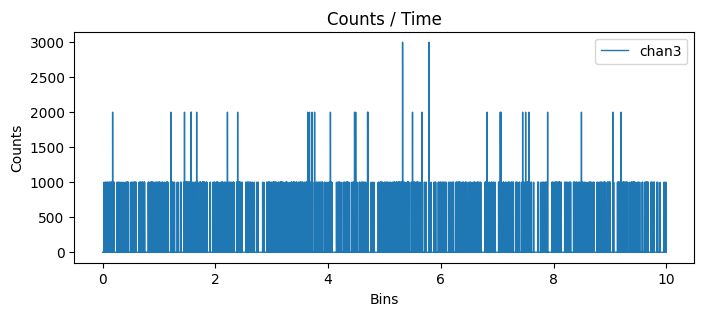

In [34]:
plt.figure(figsize=(8,3))
plt.plot(bins, data[3], linewidth=1.0, label='chan3')
plt.xlabel('Bins')
plt.ylabel('Counts')
plt.legend()
plt.title("Counts / Time")

In [35]:
sn.initDevice(MeasMode.T3)
sn.timeTrace.measure(10000,True,False)
data,bins = sn.timeTrace.getData()

Text(0.5, 1.0, 'Counts / Time')

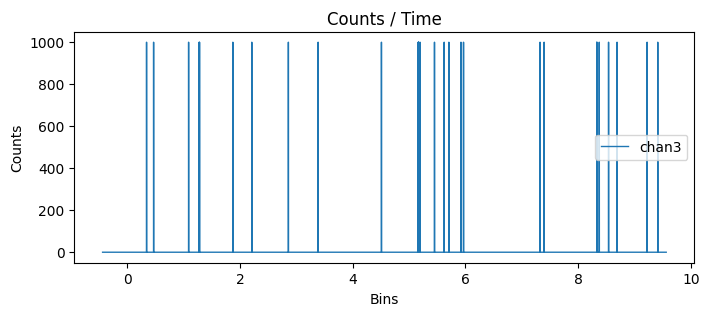

In [36]:
plt.figure(figsize=(8,3))
plt.plot(bins, data[3], linewidth=1.0, label='chan3')
plt.xlabel('Bins')
plt.ylabel('Counts')
plt.legend()
plt.title("Counts / Time")

In [32]:
np.sum(data[3])

31000.0

In [41]:
sn.getDeviceConfig()
print(sn.deviceConfig)

{'DeviceType': 0, 'FileDevicePath': '', 'ID': '1039212', 'Index': 0, 'Model': 'HydraHarp 400', 'PartNo': '930021', 'Version': '2.0', 'BaseResolution': 1.0, 'Resolution': 1.0, 'BinSteps': 26, 'NumChans': 4, 'NumMods': 4, 'SyncDivider': 1, 'ZeroxLvLSync': 20, 'DiscrLvlSync': 50, 'SyncChannelOffset': 0, 'SyncChannelEnable': 1, 'SyncDeadTime': 800, 'HystCode': 0, 'StopCount': 4294967295, 'Binning': 0, 'Offset': 0, 'lengthCode': 6, 'NumBins': 65536, 'MeasCtrl': 0, 'StartEdge': 0, 'StopEdge': 0, 'TrigOutput': 0, 'HoldoffTime': 0, 'HoldTime': 2, 'MarkerEdges': [0, 0, 0, 0], 'MarkerEna': [0, 0, 0, 0], 'ModsCfg': [{'Index': 0, 'ModelCode': 1000, 'VersionCode': 51052545}, {'Index': 1, 'ModelCode': 1010, 'VersionCode': 33554954}, {'Index': 2, 'ModelCode': 1040, 'VersionCode': 18219530}, {'Index': 3, 'ModelCode': 1040, 'VersionCode': 18219530}], 'ChansCfg': [{'Index': 0, 'DiscrLvl': 50, 'ZeroXLvl': 20, 'ChanOffs': 0, 'ChanEna': 1, 'DeadTime': 800}, {'Index': 1, 'DiscrLvl': 50, 'ZeroXLvl': 20, 'Cha

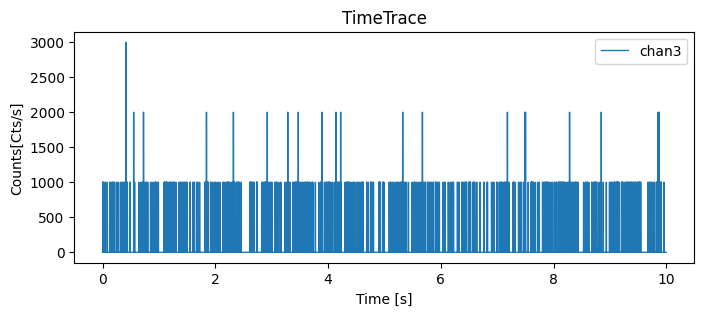

In [29]:
sn.initDevice(MeasMode.T2)
sn.timeTrace.setNumBins(10000)
sn.timeTrace.setHistorySize(10)
sn.device.setSyncDiv(0)
sn.timeTrace.measure(10000, True, False)
counts, times = sn.timeTrace.getData() 
plt.figure(figsize=(8,3))
plt.plot(times, counts[1], linewidth=1.0, label='chan3')
plt.xlabel('Time [s]')
plt.ylabel('Counts[Cts/s]')
plt.legend()
plt.title("TimeTrace")
plt.show(block=True)

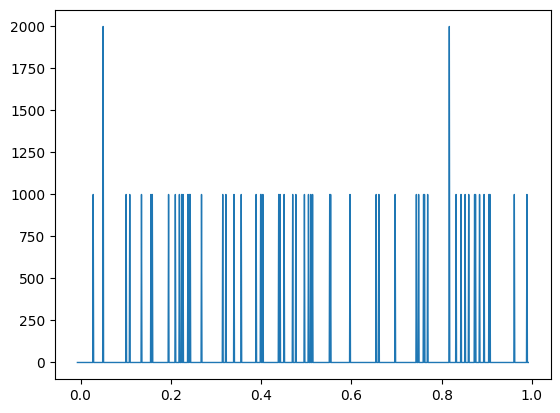

In [28]:
plt.plot(times[0:1000], counts[3][0:1000], linewidth=1.0, label='chan3')

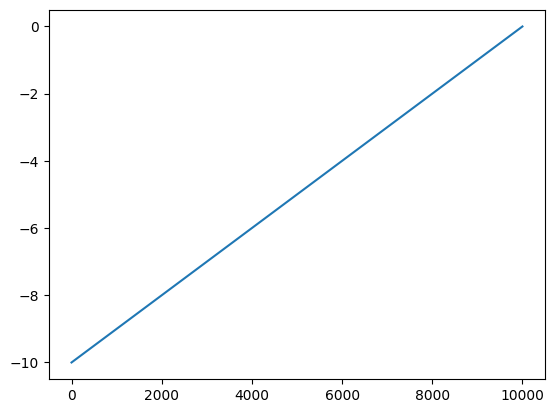

In [16]:
plt.plot(times)

In [ ]:
pip uninstall snAPI